In [226]:
# https://rhodesmill.org/skyfield/
"""
Skyfield version: 1.53
jplephem version: 2.22
sgp4 version: 2.24
Built-in leap seconds table ends with leap second at: 2016-12-31 23:59:60 UTC
Built-in ∆T table from finals2000A.all covers: 1973-01-01 to 2026-02-28
"""
import matplotlib.pyplot as plt
from skyfield.api import Loader, Topos, utc
from datetime import datetime, timedelta
import numpy as np
from datetime import datetime

# Setup Skyfield
load = Loader('~/skyfield-data')
ts = load.timescale()
eph = load('de421.bsp')
earth, sun, moon = eph['earth'], eph['sun'], eph['moon']

def convert(seconds):
    """
    Convert a float value in seconds to minutes and seconds.
    """
    minutes, sec = divmod(seconds, 60)
    return f'{int(minutes)}:{round(sec, 2)}'
    #return f'{seconds//60}:{round((seconds-(seconds//60)*60),2)}'

def convert_mn(current_time):
    # Convert the time to minutes in a day
    minutes_in_day = current_time.hour * 60 + current_time.minute
    print(f"Current time: {current_time.strftime('%H:%M:%S')}, Minutes in day: {minutes_in_day}")
    return minutes_in_day

def plot_sun_moon_altitude(latitude, longitude, date, timezone_offset=0):
    """Plot sun altitude without almanac module."""
    observer = earth + Topos(f"{latitude} N", f"{longitude} E")
    
    # Create time range (UTC)
    start = ts.utc(date.year, date.month, date.day, -timezone_offset, range(0, 1440, 1))
    sun_apparent = observer.at(start).observe(sun).apparent()
    moon_apparent = observer.at(start).observe(moon).apparent()
    sun_alt, sun_az, _ = sun_apparent.altaz()
    moon_alt, moon_az, _ = moon_apparent.altaz()
    #print(alt.degrees, len(alt.degrees), max(alt.degrees))
    #print(az.degrees)#, len(alt.degrees), max(alt.degrees))
    # Convert to local hours
    hours = np.linspace(0, 24, len(sun_alt.degrees))
    # Get the current time
    current_time = datetime.now()
    
    #print(np.sign(alt.degrees), np.diff(np.sign(alt.degrees)),np.where(np.diff(np.sign(alt.degrees))))
    # Find sunrise/sunset crossings manually
    noon = convert(np.argmax(sun_alt.degrees)+1)
    crossings = np.where(np.diff(np.sign(sun_alt.degrees)))[0]
    sunrise = convert(crossings[0]-4)
    sunset = convert(crossings[1]+5)
    now_mn = convert_mn(current_time)
    print(f'Sunrise at: {sunrise} - Sunset at: {sunset} Noon: {noon}')
    print(f'Altitude: {sun_alt.degrees[now_mn]} - Azimuth: {sun_az.degrees[now_mn]}')
    # Plot
    fig, ax = plt.subplots(1, 1,figsize=(12, 6))
    plt.plot(hours, sun_alt.degrees, 'b-')
    plt.plot(hours, moon_alt.degrees, 'g-.')
    plt.plot(hours[now_mn], sun_alt.degrees[now_mn],'ro',label=f'Sun alt : {round(sun_alt.degrees[now_mn],2)}\nSun az : {round(sun_az.degrees[now_mn],2)}')
    plt.plot(hours[now_mn], moon_alt.degrees[now_mn],'go',label=f'Moon alt : {round(moon_alt.degrees[now_mn],2)}\nMoon az : {round(moon_az.degrees[now_mn],2)}')
    plt.axhline(0, color='gray', linestyle='--')
    
    # Mark crossings
    for i in crossings:
        if sun_alt.degrees[i] < 0:  # Sunrise
            plt.axvline(hours[i], color='orange', linestyle=':', label=f'Sunrise : {sunrise}' if i == crossings[0] else "")
        else:  # Sunset
            plt.axvline(hours[i], color='red', linestyle=':', label=f'Sunset : {sunset}' if i == crossings[1] else "")
    
    plt.title(f"Sun-Moon Altitude on {date.strftime('%Y-%m-%d')}")
    plt.xlabel('Local Time (hours)')
    plt.ylabel('Altitude (degrees)')
    #plt.xticks()
    ax.set_xticks(range(0,24), labels=[str(i) for i in range(0,24)])
    plt.legend()
    plt.grid()
    plt.show()


Current time: 09:54:39, Minutes in day: 594
Sunrise at: 6:24 - Sunset at: 21:10 Noon: 13:48
Altitude: 33.03767891826538 - Azimuth: 103.54335825111214


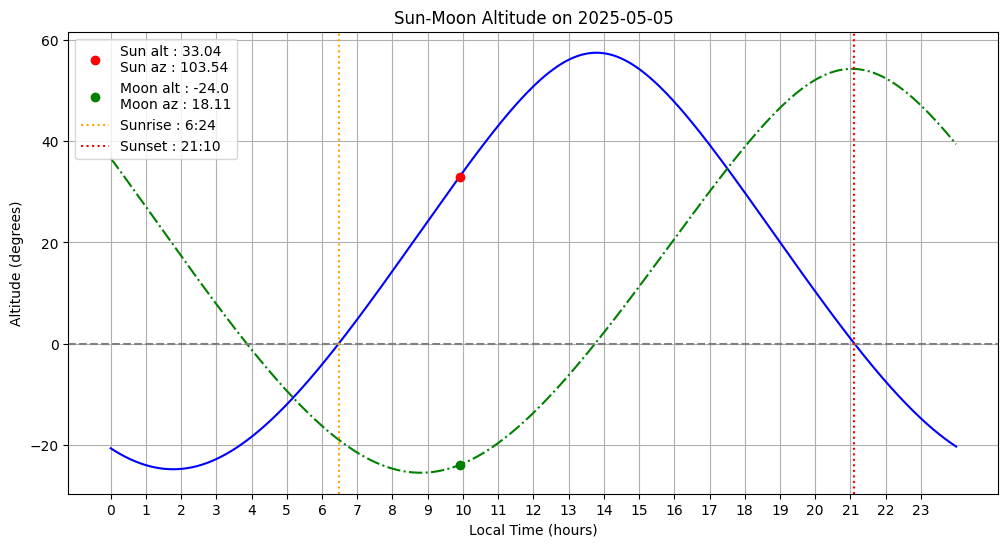

In [227]:

# Example usage
plot_sun_moon_altitude(
    latitude=48.881953,
    longitude=2.526959,
    date=datetime.now().date(),
    timezone_offset=2
)


Current time: 10:14:51, Minutes in day: 614


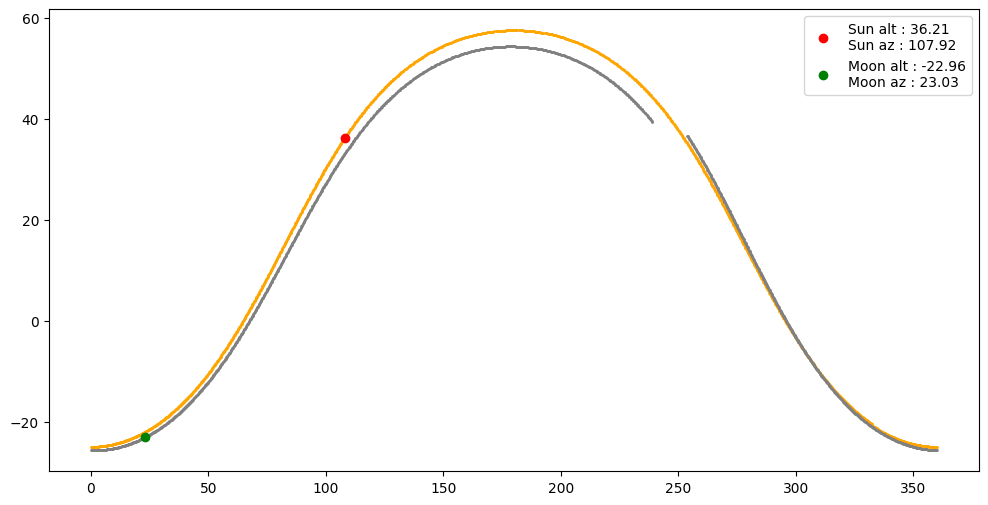

In [243]:
"""Scatter altitude, azimuth without almanac module."""
latitude=48.881953
longitude=2.526959
date=datetime.now().date()
timezone_offset=2
observer = earth + Topos(f"{latitude} N", f"{longitude} E")

# Create time range (UTC)
start = ts.utc(date.year, date.month, date.day, -timezone_offset, range(0, 1440, 1))
sun_apparent = observer.at(start).observe(sun).apparent()
moon_apparent = observer.at(start).observe(moon).apparent()
sun_alt, sun_az, _ = sun_apparent.altaz()
moon_alt, moon_az, _ = moon_apparent.altaz()
# Get the current time
current_time = datetime.now()
now_mn = convert_mn(current_time)
# Plot
fig, ax = plt.subplots(1, 1,figsize=(12, 6))
plt.scatter(sun_az.degrees, sun_alt.degrees,s=1,color='orange')
plt.scatter(moon_az.degrees, moon_alt.degrees,s=1,color='grey')
plt.plot(sun_az.degrees[now_mn], sun_alt.degrees[now_mn],'ro',label=f'Sun alt : {round(sun_alt.degrees[now_mn],2)}\nSun az : {round(sun_az.degrees[now_mn],2)}')
plt.plot(moon_az.degrees[now_mn], moon_alt.degrees[now_mn],'go',label=f'Moon alt : {round(moon_alt.degrees[now_mn],2)}\nMoon az : {round(moon_az.degrees[now_mn],2)}')
   
plt.legend()

In [235]:
def plot_sun_moon_azimuth(latitude, longitude, date, timezone_offset=0):
    """Plot sun altitude without almanac module."""
    observer = earth + Topos(f"{latitude} N", f"{longitude} E")
    
    # Create time range (UTC)
    start = ts.utc(date.year, date.month, date.day, -timezone_offset, range(0, 1440, 1))
    sun_apparent = observer.at(start).observe(sun).apparent()
    moon_apparent = observer.at(start).observe(moon).apparent()
    sun_alt, sun_az, _ = sun_apparent.altaz()
    moon_alt, moon_az, _ = moon_apparent.altaz()
    #print(alt.degrees, len(alt.degrees), max(alt.degrees))
    #print(az.degrees)#, len(alt.degrees), max(alt.degrees))
    # Convert to local hours
    hours = np.linspace(0, 24, len(sun_alt.degrees))
    # Get the current time
    current_time = datetime.now()
    
    #print(np.sign(alt.degrees), np.diff(np.sign(alt.degrees)),np.where(np.diff(np.sign(alt.degrees))))
    # Find sunrise/sunset crossings manually
    noon = convert(np.argmax(sun_alt.degrees)+1)
    crossings = np.where(np.diff(np.sign(sun_alt.degrees)))[0]
    sunrise = convert(crossings[0]-4)
    sunset = convert(crossings[1]+5)
    now_mn = convert_mn(current_time)
    print(f'Sunrise at: {sunrise} - Sunset at: {sunset} Noon: {noon}')
    print(f'Altitude: {sun_alt.degrees[now_mn]} - Azimuth: {sun_az.degrees[now_mn]}')
    # Plot
    fig, ax = plt.subplots(1, 1,figsize=(12, 6))
    plt.plot(hours, sun_az.degrees, 'b-')
    plt.plot(hours, moon_az.degrees, 'g-.')
    plt.plot(hours[now_mn], sun_az.degrees[now_mn],'ro',label=f'Sun alt : {round(sun_alt.degrees[now_mn],2)}\nSun az : {round(sun_az.degrees[now_mn],2)}')
    plt.plot(hours[now_mn], moon_az.degrees[now_mn],'go',label=f'Moon alt : {round(moon_alt.degrees[now_mn],2)}\nMoon az : {round(moon_az.degrees[now_mn],2)}')
    plt.axhline(0, color='gray', linestyle='--')
    
    # Mark crossings
    for i in crossings:
        if sun_alt.degrees[i] < 0:  # Sunrise
            plt.axvline(hours[i], color='orange', linestyle=':', label=f'Sunrise : {sunrise}' if i == crossings[0] else "")
        else:  # Sunset
            plt.axvline(hours[i], color='red', linestyle=':', label=f'Sunset : {sunset}' if i == crossings[1] else "")
    
    plt.title(f"Sun-Moon Azimuth on {date.strftime('%Y-%m-%d')}")
    plt.xlabel('Local Time (hours)')
    plt.ylabel('Altitude (degrees)')
    #plt.xticks()
    ax.set_xticks(range(0,24), labels=[str(i) for i in range(0,24)])
    plt.legend()
    plt.grid()
    plt.show()

Current time: 10:04:51, Minutes in day: 604
Sunrise at: 6:24 - Sunset at: 21:10 Noon: 13:48
Altitude: 34.62999256622705 - Azimuth: 105.70366848168496


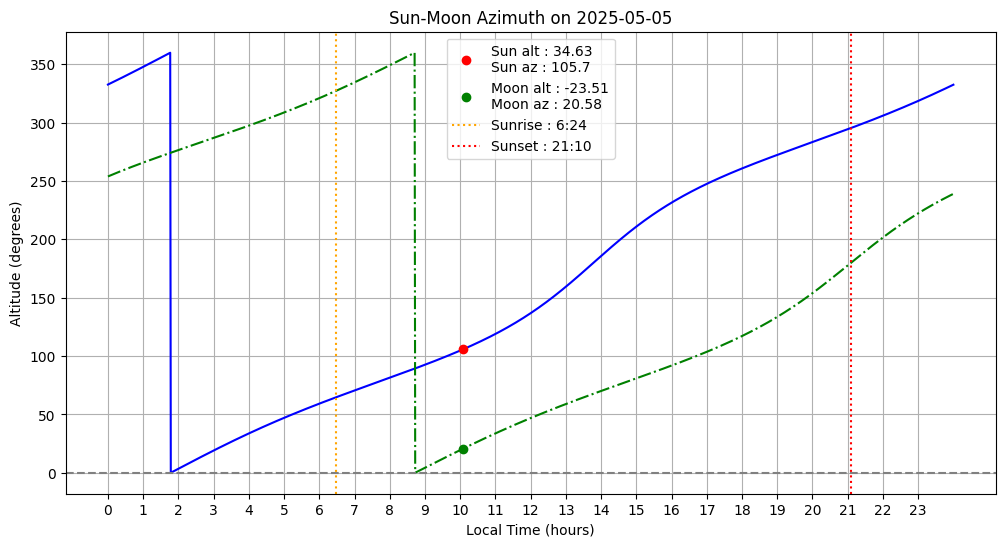

In [236]:
# Example usage
plot_sun_moon_azimuth(
    latitude=48.881953,
    longitude=2.526959,
    date=datetime.now().date(),
    timezone_offset=2
)